In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 5fd22109-7e01-4065-9ca2-9a71dffe7c8e

In [2]:
import Local_NAV as local
from Global_NAV import *
import Motion_CTR_2 as mctrl
import Kalman_FIL as kfil
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import IPython
from IPython.display import display, clear_output
import time

from matplotlib import colors
from cvision2 import *

%matplotlib inline

ModuleNotFoundError: No module named 'Motion_CTR_2'

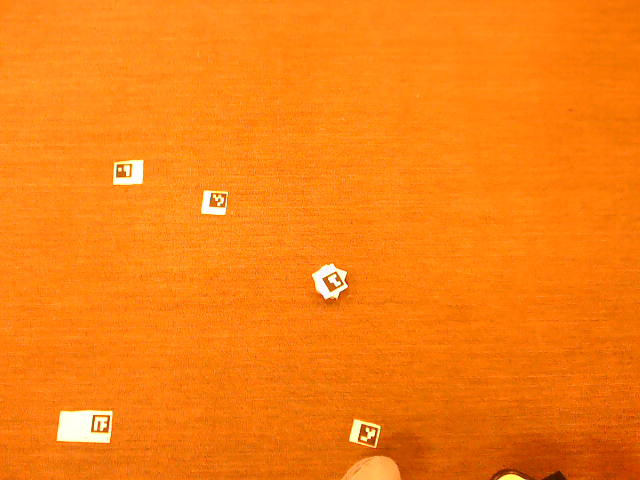

Thymio map pos [[815.27685615 596.71164197]]
Thymio map dir -2.6632402222111358


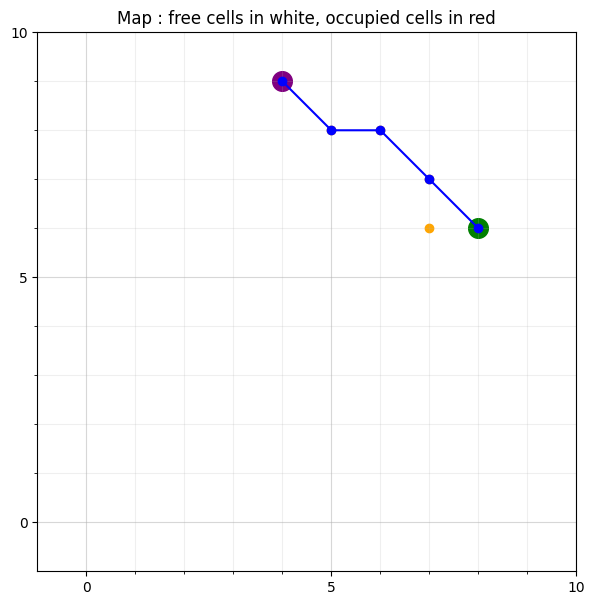

N 5
[815.27685615 596.71164197  -2.66324022]
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [800, 600]
Theta goal 0.8401941512798778
v,w 10 -0.552294764770268
vr, vl :  -63.27982812492816 131.31555735577913
Z_k  [817.50339213 596.80844788  -2.66324022]
St est [817.23352032 596.71159894  -2.11712137]
k:  1
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [700, 700]
Theta goal 0.8187049405876587
v,w 10 -1.4368589909452751
vr, vl :  -218.7717234724582 287.31429637819525
Z_k  [813.0936228  604.52185712  -3.00904112]
St est [8.13216619e+02 6.03735966e+02 3.91612254e-01]
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [700, 700]
Theta goal 0.8293819990154159
v,w 10 0.6126611933784208
vr, vl :  141.5003388418281 -74.1321140628152
Z_k  [816.14654003 612.55973099   2.28653992]
St est [815.93719155 612.36846404   2.08359176]
obstacles [0, 0, 0, 0, 0]
THE STATE IS :  1
Pth [700, 700]
Theta goal 0.8567243128467652
v,w 10 0.11099799815552416
vr, vl :  53.316170023911965 14.339501172102612
Z_k  [815

KeyboardInterrupt: 

In [5]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 104
R = 20
Ts = 0.5 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 80

path = []
while True:
    if state == 0:
        # Create an adjusted dictionary of 5 ArUco markers of 4x4 bits and a detector of these markers.
        aruco_dictionary = cv2.aruco.extendDictionary(5, 4)
        detector = create_detector(aruco_dictionary)
        # Print a marker for each objects to be recognized on the map
        for i in range(5):
            marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
            cv2.imwrite('marker' + str(i) +'.jpg', marker)
        # Definition of the references used to map the space
        ref1 = Obj(0, np.array([[0,0]]))
        ref2 = Obj(1, np.array([[0,0]]))
        ref3 = Obj(2, np.array([[0,0]]))

        # Definition of the objects to recognize in the space
        goal = Obj(3, np.array([[]]))
        thymio = Obj(4, np.array([[]]))
        map = Map(ref1,ref2,ref3,640,640)
        objects = np.array([ref1,ref2, ref3, goal, thymio])

        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                
                clear_output(wait=True)
                #show_frame(frame)
                new_frame = frame.copy()
                
                detect_objects(frame, detector, objects)

                if map.references_detected():
                    matrix = map.matrix(frame,thymio,goal)
                    if np.size(map.localize(thymio), 0) > 0:
                        print('Thymio map pos', map.localize(thymio))
                        print('Thymio map dir', vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0])))
                    if check_matrix(matrix):
                        path,visitedNodes = global_path(matrix)
                        print_path(matrix,path,visitedNodes)
                        path = np.multiply(path, 100)
                        N = np.size(path,1)
                        print("N" ,N)
                        path_found = True
                        state_estimate_k = np.array([map.localize(frame,thymio)[0][0],map.localize(frame,thymio)[0][1],vector_to_angle(thymio.get_img_dir()[0])])
                        print(state_estimate_k)

        # Navigation
        state = 1    
        # Global navigation state
        if state == 1:

            while not_arrived == True:
                #Check if there is obstacles
                prox_horizontal = local.read_prox_sensors(node,client)
                obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
                print("obstacles",obst)
                state = local.update_state(state,obst,client)

                # Update temporary goal
                print("Pth", [path[0,k],path[1,k]])
                if k < N-1:
                    theta_goal_temp = (math.atan2(path[1,k+1]-state_estimate_k[1], path[0,k+1]-state_estimate_k[0]) + np.pi) % (np.pi/2)
                    print('Theta goal',theta_goal_temp)
                v, w = mctrl.control_law(state_estimate_k, path[0,k], path[1,k], theta_goal_temp)
                print("v,w",v,w)
                vr, vl = mctrl.convert_velocity2RL(v,w,C_conv_toThymio_right, C_conv_toThymio_left,L,R)
                print("vr, vl : ",vr,vl)
                vr = int(vr)
                vl = int(vl)
                mctrl.set_motors(vl,vr,node)
                
                camera_obstructed = 1
                # Check if camera is obstructed
                if video.isOpened:
                    ret, frame = video.read()
                    new_frame = frame.copy()
                    if ret == True:
                        #clear_output(wait=True)
                        detect_objects(frame, detector, objects)
                        """ ref1.draw(new_frame, [255,0,0])
                        ref2.draw(new_frame, [0,255,0])
                        ref3.draw(new_frame, [0,0,255])
                        goal.draw(new_frame, [255,255,255])
                        thymio.draw(new_frame, [255,100,100])
                        show_frame(new_frame) """
                        z_k_observation_vector = np.array([state_estimate_k[0], state_estimate_k[1], state_estimate_k[2]])
                        if map.references_detected():
                            if np.size(map.localize(thymio), 0) > 0:
                                camera_obstructed = 0
                                #print('Path :', path)
                                z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))]) 
                                print("Z_k ", z_k_observation_vector)
                                P_k_minus_1 = P_k
                                state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)
                                print("St est", state_estimate_k)
                        state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)
                if np.linalg.norm(state_estimate_k[:2] - np.array([path[0,k], path[1,k]])) < threshold_for_convergence:
                    k = k+1
                    print("k: ", k)
                    if k == N-1:
                        not_arrived = False
                        print('The robot has arrived to the final goal')
                        mctrl.stop_motors(node)

                        break 
                time.sleep(Ts)                                             
        # Local navigation state
        if state == 2: 
            print("Local aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa")
            
            #We get the sensor value
            prox_horizontal = local.read_prox_sensors(node,client)
            
            #We fill the obst list with the sensor value
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            
            #We calculate the motor speed to avoid the object -> potential field method
            motors_speed = local.local_navigation(obst)
            
            #We set the motor speed
            mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
            
            #We update the state
            state = local.update_state(state,obst,client)   


In [ ]:
motors_speed = local.global_path()
local.set_motors(motors_speed[0],motors_speed[1],node) 
local.stop_motors(node) 


AttributeError: module 'Local_NAV' has no attribute 'global_path'

In [6]:
mctrl.stop_motors(node)